 This file contains functions that can be easily used for other parts of the experiment.
 To make new data mods, duplicate this file and add a new function to replace "basic_preprocessing" in this pipeline.

In [107]:
from ipynb.fs.full.create_dataframe import read_data
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.optimizers import Adam
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix
from random import choice,sample

In [108]:
# create dataframe using other file's code
reptiles=read_data(["Lizard","Toad"])
reptiles.target.value_counts()

Turtle_Tortoise        500
Crocodile_Alligator    500
Snake                  500
Frog                   498
Salamander             468
Iguana                 466
Chameleon              390
Gecko                  297
Name: target, dtype: int64

In [109]:
def basic_preprocess(dataframe):
    # Basic preprocessing 

    # prepare X
    img_list = list(dataframe['image'])

    data_img = []
    for each in img_list:
                each_img = cv2.cvtColor(each, cv2.COLOR_BGR2RGB)
                #Resize the images:
                each_img_resized = cv2.resize(each_img, (128,128))
                #Save arrays to a list:
                data_img.append(each_img_resized)
    # Converting list to numpy array
    X = np.array(data_img)

    # prepare y
    y = OneHotEncoder(dtype='int8', sparse=False).fit_transform(dataframe['target'].values.reshape(-1,1))

    return X,y


In [110]:
s=3500
reptiles["target"][s]

'Snake'

In [111]:
y[s]

array([0, 0, 0, 0, 0, 0, 1, 0], dtype=int8)

In [112]:
X,y= basic_preprocess(reptiles) ## replace this to change preprocessing

X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_val shape  : ', X_val.shape)
print('y_val shape  : ', y_val.shape)
print('X_test shape : ', X_test.shape)
print('y_test shape : ', y_test.shape)


X_train shape:  (2460, 128, 128, 3)
y_train shape:  (2460, 8)
X_val shape  :  (616, 128, 128, 3)
y_val shape  :  (616, 8)
X_test shape :  (543, 128, 128, 3)
y_test shape :  (543, 8)


In [113]:
def fit_model(X_train,y_train,X_val):
    #  code adapted from:
    #  https://pub.towardsai.net/multiclass-image-classification-hands-on-with-keras-and-tensoflow-e1cf434f3467


    train_gen = ImageDataGenerator(horizontal_flip=True,
                               rotation_range = 45,
                               zoom_range=0.2,
                               height_shift_range = 0.5,
                               width_shift_range = 0.5)
    validation_gen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range = 45,
                                    zoom_range=0.2,
                                    height_shift_range = 0.5,
                                    width_shift_range = 0.5)
    train_gen.fit(X_train)
    validation_gen.fit(X_val)
    batch_size = 64
    epochs = 10
    base = Xception(include_top=False, 
                weights='imagenet', 
                input_shape=(128,128,3))
    x = base.output
    x = GlobalAveragePooling2D()(x)
    head = Dense(y_train.shape[1], activation='softmax')(x)
    model = Model(inputs=base.input, outputs=head)
    model.compile(optimizer=Adam(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'], run_eagerly=True)
    
    fit = model.fit_generator(
               train_gen.flow(X_train, y_train,
               batch_size=batch_size),
               epochs = epochs,
               validation_data = validation_gen.flow(X_val, y_val)
)

    return model,fit

In [114]:
model,fit=fit_model(X_train,y_train,X_val)

/Users/erikafox/opt/miniconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/5b/sjkc4b8n0hs41zd03hxr66100000gn/T/ipykernel_32631/3622201608.py:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit = model.fit_generator(


Epoch 1/10
39/39 [==============================] - 210s 5s/step - loss: 1.9002 - accuracy: 0.2837 - val_loss: 1.8785 - val_accuracy: 0.3409
Epoch 2/10
39/39 [==============================] - 208s 5s/step - loss: 1.4402 - accuracy: 0.5199 - val_loss: 1.5219 - val_accuracy: 0.5487
Epoch 3/10
39/39 [==============================] - 208s 5s/step - loss: 1.0891 - accuracy: 0.6370 - val_loss: 1.3186 - val_accuracy: 0.6201
Epoch 4/10
39/39 [==============================] - 209s 5s/step - loss: 0.8994 - accuracy: 0.6886 - val_loss: 1.0257 - val_accuracy: 0.6737
Epoch 5/10
39/39 [==============================] - 207s 5s/step - loss: 0.8099 - accuracy: 0.7297 - val_loss: 0.9813 - val_accuracy: 0.6834
Epoch 6/10
39/39 [==============================] - 205s 5s/step - loss: 0.7065 - accuracy: 0.7687 - val_loss: 0.9027 - val_accuracy: 0.7062
Epoch 7/10
39/39 [==============================] - 209s 5s/step - loss: 0.6016 - accuracy: 0.8049 - val_loss: 0.8263 - val_accuracy: 0.7256
Epoch 8/10
25

In [ ]:
def make_plots(model_fit):
    history_df = pd.DataFrame(model_fit.history)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history_df['loss'], label='training loss')
    plt.plot(history_df['val_loss'], label='validation loss')
    plt.title('Model Loss Function')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history_df['accuracy'], label='training accuracy')
    plt.plot(history_df['val_accuracy'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.legend();

def getPredTestClasses(model):
    y_pred = model.predict(X_test)
    # Converting prediction classes from one hot encoding to list
    # Argmax returns the position of the largest value
    y_pred_classes = np.argmax(y_pred, axis = 1)
    # Convert test labels from one hot encoding to list
    y_test_classes = np.argmax(y_test, axis = 1)
    return y_test_classes,y_pred_classes

def make_conf_matrix(y_test_classes,y_pred_classes):
    # Create the confusion matrix
    confmx = confusion_matrix(y_test_classes, y_pred_classes)
    f, ax = plt.subplots(figsize = (8,8))
    sns.heatmap(confmx, annot=True, fmt='.1f', ax = ax)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show();

17/17 [==============================] - 10s 586ms/step


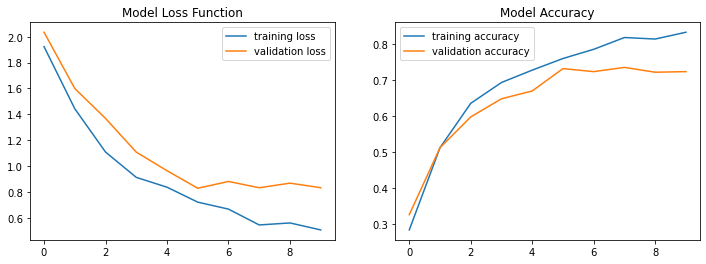

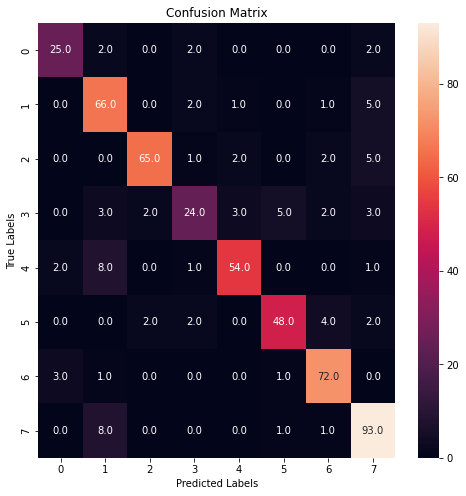

In [ ]:
make_plots(fit)

y_test_classes,y_pred_classes= getPredTestClasses(model)
make_conf_matrix(y_test_classes,y_pred_classes)


In [ ]:
predicted=pd.DataFrame({"True":y_test_classes,"Pred":y_pred_classes})

# change classes to actual labels
label_key = {0 : 'Chameleon', 1 : 'Crocodile',2:"Frog", 3: 'Gecko', 4 : 'Iguana', 5: 'Salamander', 6:"Snake", 7:"Turtle"}
predicted=predicted.replace({"True": label_key,"Pred":label_key})

In [ ]:
def show_sample_misclassified(predicted):
    misclassified=predicted.loc[~(predicted['True'] == predicted['Pred'])]
    indices = sample(misclassified.index.to_list(),8)
    i = 1
    plt.figure(figsize=(14,7))
    for each in indices:
        plt.subplot(2,4,i)
        plt.imshow(Image.fromarray(X_test[each]))
        plt.title("True:"+misclassified['True'].loc[each]+"\nPredicted: "+misclassified['Pred'].loc[each])
        plt.xticks([])
        plt.yticks([])
        i += 1

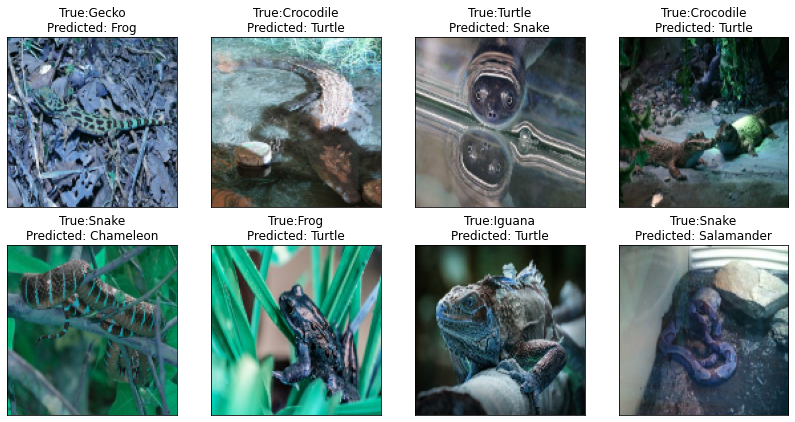

In [ ]:
show_sample_misclassified(predicted)